In [0]:
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
transforms_train = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

transforms_test = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

batch_sizes = 128

train_data = datasets.CIFAR10(root='./train', download=True, transform=transforms_train)
test_data = datasets.CIFAR10(root='./test', train=False, download=True, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
images, labels = next(iter(train_data_loader))

In [0]:
def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(60, 8))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title is not None:
        plt.title(title)
    plt.show

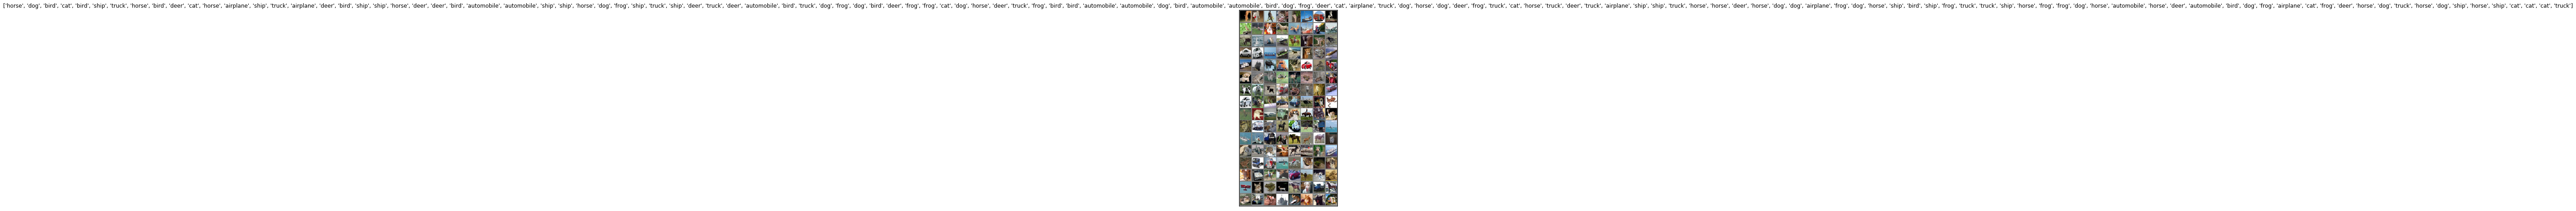

In [0]:
image_display(torchvision.utils.make_grid(images), [train_data.classes[x] for x in labels])

In [0]:
class Batch_Norm_Relu_Conv2d(nn.Module):
    
    def __init__(self, number_in_channels, number_out_channels, kernel_size, stride, padding):
        
        super(Batch_Norm_Relu_Conv2d, self).__init__()
        
        self.batch_normalization = nn.BatchNorm2d(number_in_channels)
        
        self.relu = nn.ReLU()
        
        self.conv2d = nn.Conv2d(number_in_channels, number_out_channels, kernel_size=kernel_size, 
                                stride=stride, padding=padding, bias=False)
        
    def forward(self, x):
        
        batch_normalized_input = self.batch_normalization(x)
        
        relu_activated_input = self.relu(batch_normalized_input)
        
        return self.conv2d(relu_activated_input)
 
    

In [0]:
class Residual_Unit(nn.Module):
    
    def __init__(self, number_in_channels, number_out_channels, kernel_size, stride, padding, drop_out_value):
        
        super(Residual_Unit, self).__init__()
        
        self.batch_norm_relu1 = Batch_Norm_Relu_Conv2d(number_in_channels, 
                                             number_out_channels, kernel_size, stride, padding)
        
        self.batch_norm_relu2 = Batch_Norm_Relu_Conv2d(number_out_channels, 
                                             number_out_channels, kernel_size, 1, padding)
        
        self.dropout = nn.Dropout2d(p=drop_out_value)
        
        self.identity_function = nn.Sequential(nn.Conv2d(number_in_channels, number_out_channels, 1, stride, 
                                               0)) if stride == 2 or number_in_channels != number_out_channels else nn.Sequential()
        
        self.dropout = nn.Dropout2d(p=drop_out_value)
        
        
    def forward(self, x):
        
        x_input = self.identity_function(x)
        
        y_input = x
        
        y_input = self.dropout(self.batch_norm_relu1(y_input))
        
        y_input = self.batch_norm_relu2(y_input)
        
        y_output = x_input + y_input
        
        return y_output
        

In [0]:
class Residual_Block(nn.Module):
    
    def __init__(self, number_in_channels, number_out_channels, kernel_size, 
                                stride, padding, drop_out_value, number_of_residual_units):
        
        super(Residual_Block, self).__init__()
        
        residual_units = []
        
        residual_units.append(Residual_Unit(number_in_channels, number_out_channels, kernel_size, 
                                                            stride, padding, drop_out_value))
        
        for i in range(number_of_residual_units - 1):
            
            residual_units.append(Residual_Unit(number_out_channels, number_out_channels, kernel_size, 
                                                            1, padding, drop_out_value))
            
        self.residual_block = nn.Sequential(*residual_units)
        
        
        
    def forward(self, x):
        
        residual_block_input = x
        
        residual_block_output = self.residual_block(residual_block_input)
        
        return residual_block_output
        

In [0]:
class WideResNet(nn.Module):
    
    def __init__(self, depth, drop_out_value, num_classes=len(train_data.classes), widing_factor_k=1):
        
        super(WideResNet, self).__init__()
        
        n = (depth-4)/6
        
        number_of_residual_units = int(n)
        
        self.first_conv_layer = nn.Conv2d(3, 16, 3, 1, 1)
        
        self.residual_block1 = Residual_Block(16, 16*widing_factor_k, 3, 1, 1, drop_out_value, number_of_residual_units)
        
        self.residual_block2 = Residual_Block(16*widing_factor_k,32*widing_factor_k, 3, 2, 1, drop_out_value, number_of_residual_units)
        
        self.residual_block3 = Residual_Block(32*widing_factor_k, 64*widing_factor_k, 3, 2, 1, drop_out_value, number_of_residual_units)
        
        self.batch_normalization = nn.BatchNorm2d(64*widing_factor_k)
        
        self.global_average_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Linear(64*widing_factor_k, num_classes)
        
        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                
                nn.init.constant_(m.bias, 0)

       
    def forward(self, x):
        
        y = F.relu(self.first_conv_layer(x))
        
        y = self.residual_block1(y)
        
        y = self.residual_block2(y)
        
        y = F.relu(self.batch_normalization(self.residual_block3(y)))
        
        y = self.global_average_pool(y)
        
        y = y.view(y.size(0),-1)
        
        output_logit = self.classifier(y)

        return output_logit
        

In [0]:
Model = WideResNet(16, 0.25, widing_factor_k=10) 

lr = 0.01

criteria = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(Model.parameters(), lr=lr, momentum=0.9)

milestones = [70, 100, 150]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def model_traing_and_validation_loop(Model, n_epochs, save_path):
    
    n_epochs = n_epochs

    saving_criteria_of_model = 0

    training_loss_array = []

    validation_loss_array = []

    Model = Model.to(device)

    for i in range(n_epochs):

        total_test_data = 0

        total_train_data = 0

        correct_test_data = 0

        training_loss = 0

        validation_loss = 0

        for data, target in train_data_loader:

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            logit = Model(data)

            loss = criteria(logit, target)

            loss.backward()

            optimizer.step()

            training_loss += loss.item()*data.size(0)

        scheduler.step()

        with torch.no_grad():

            for data, target in test_data_loader:

                data, target = data.to(device), target.to(device)

                logit = Model(data)

                _, prediction = torch.max(logit, 1) 

                loss = criteria(logit, target)

                total_test_data += target.size(0)

                correct_test_data += (prediction == target).sum().item()

                validation_loss += loss.item()*data.size(0)
                
        training_loss = training_loss / len(train_data)
        
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)

        validation_loss_array.append(validation_loss)

        validation_accuracy = correct_test_data / total_test_data

        print(f'{i+1} / {n_epochs} Training loss: {training_loss}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_accuracy}')

        if saving_criteria_of_model < validation_accuracy:

            torch.save(Model, save_path)
            
            saving_criteria_of_model = validation_accuracy
            
            print('--------------------------Saving Model---------------------------')
         
        
    plt.figure(figsize=(20, 4))
        
    x_axis = (range(n_epochs))
        
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
        
    plt.title('A gragh of training loss vs validation loss')
        
    plt.legend(['train loss', 'validation loss'])
        
    plt.xlabel('Number of Epochs')
        
    plt.ylabel('Loss')
        
    return Model


In [0]:
n_epochs = 200
start = time.perf_counter()
model = model_traing_and_validation_loop(Model, n_epochs, 'WideResNet.pt')
end = time.perf_counter()
print(f'Total time spent {(end - start)/60}minutes')

1 / 200 Training loss: 1.741690944519043, Validation_loss: 1.5173682022094725, Validation_Accuracy: 0.4231
--------------------------Saving Model---------------------------


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type WideResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Residual_Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Residual_Unit. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Batch_Norm_Relu_Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked

2 / 200 Training loss: 1.419212813644409, Validation_loss: 1.3280671802520752, Validation_Accuracy: 0.5173
--------------------------Saving Model---------------------------


In [0]:
load_saved_model = torch.load('WideResNet.pt')

In [0]:
dummy_input = torch.FloatTensor(1,3,224,224)
dummy_input = dummy_input.to(device)

In [0]:
torch.onnx.export(load_saved_model, dummy_input, 'WideResNet.onnx')